## Requisito 1

### Importanto los módulos necesarios

In [596]:
import pandas as pd
import numpy as np
import random
from scipy.stats import truncnorm

### Primera configuración del primer dataset

In [599]:
d1 = {
 "ds": "dataset1",
 "columns": [
 {
 "name": "area",
 "type": "category",
 "values": ["TI", "FIN", "HR"]
 },
 {
 "name": "id",
 "type": "unique"
 }
 ],
 "random": False
}
 

### Función para obtener números aleatorios, recibe un mínimo, un máximo y la cantidad de valores que se desean generar aleatoriamente

In [602]:
def get_random_numbers( min , max, n ):
    values = []
    for i in range(n):
        values.append(
            random.uniform(min, max)
        )
    return values

In [604]:
def get_random_categories( items , n  ):
    return random.choices(items, k=n)

def get_random_dates( min , max , n ):
    items = pd.date_range( start = min , end = max , freq = 'D' )
    return get_random_categories( items , n )

def get_unique_category_values(column):
    return list(set(column))

In [606]:
def generate_truncated_normal_data(mean, std, min_val, max_val, size):
    # Calcular los parámetros de la distribución normal truncada
    a, b = (min_val - mean) / std, (max_val - mean) / std
    data = truncnorm(a, b, loc=mean, scale=std).rvs(size)
    return data

In [608]:
# Funcion para ordenar los datasets
def sort_datasets(datasets):
    sorted_datasets = []  # Lista donde almacenaremos los datasets ordenados
    remaining_datasets = datasets[:]  # Copia de la lista original de datasets para ir eliminando los ya ordenados
    dataset_dict = {ds['ds']: ds for ds in datasets}  # Diccionario para mapear datasets por su nombre
    dataset_dependencies = {ds['ds']: set() for ds in datasets}  # Diccionario para almacenar las dependencias de cada dataset

    # Construir el diccionario de dependencias
    for ds in datasets:
        for col in ds['columns']:
            if col['type'] == 'foreign':
                referenced_ds, _ = col['values'].split('.')
                # Agregar la dependencia al dataset actual
                dataset_dependencies[ds['ds']].add(referenced_ds)
                # Lanzar error si el dataset de referencia no existe.
                if referenced_ds not in dataset_dict:
                    raise ValueError(f"El dataset de referencia '{referenced_ds}' no existe.")
                dataset_dependencies[ds['ds']].add(referenced_ds)
    
    # Proceso de ordenamiento topológico
    while remaining_datasets:
        # Iterar sobre una copia de remaining_datasets para poder modificarlo
        for dataset in remaining_datasets[:]:
            dataset_name = dataset['ds']
            # Verificar si todas las dependencias de este dataset están satisfechas
            deps_satisfied = all(dep not in dataset_dependencies for dep in dataset_dependencies[dataset_name])
            
            if deps_satisfied:
                # Si todas las dependencias están satisfechas, añadir el dataset a sorted_datasets
                sorted_datasets.append(dataset)
                # Eliminar el dataset ordenado de remaining_datasets
                remaining_datasets.remove(dataset)
                # Eliminar las dependencias satisfechas de dataset_dependencies
                dataset_dependencies.pop(dataset_name, None)
    
    return sorted_datasets

### Importamos el módulo uuid para generar números aleatorios de 16 bytes lo que es útil para generar id únicos, en este caso solo se seleccionan los primeros 16 caracteres para dicho id

In [611]:
import uuid
def generate_unique_values(n):
    values = []
    for i in range(n):
        unique_id = uuid.uuid4()
        values.append(str(unique_id).replace('-', '')[:16])
    return values

In [613]:

def build_dataframes(conf_list):
    df_list = {}

    sorted_conf_list = sort_datasets(conf_list)
    
    for settings in sorted_conf_list :
        df_generated = {}
        types = ['category', 'unique', 'numeric', 'date', 'foreign']
        columns = settings['columns']
    
        num_records = 0
        column_not_random = -1
        
        if(settings['random'] == False) :
            for index, col in enumerate(columns):
                if col['type'] in types:
                    if col['type'] == 'category':
                        num_records = max(num_records, len(col['values']))
                        if num_records <=  len(col['values']):
                            column_not_random = index
                           
                    elif col['type'] == 'date':
                        num_records = max(num_records, len(pd.date_range(start=col['values']['min'], end=col['values']['max'], freq='D')) )
                        if num_records <= len(pd.date_range(start=col['values']['min'], end=col['values']['max'], freq='D')):
                            column_not_random = index
                            
                else : 
                    raise TypeError(f"El tipo {col['type']} no es soportado")
            
                        
        if settings['random'] :
            if 'random_rows' in settings:
                num_records = settings['random_rows']
            else:
                raise TypeError("La columna 'random_rows' es obligatoria si se configura 'random = True'.")
        
        for index, column in enumerate(columns):
            if column['type'] in types:
                
                if column['type'] == 'category':
                    if column_not_random == index :
                        values = column['values']
                    else:
                        values = get_random_categories( column['values'] , num_records  )
    
                if column['type'] == "numeric":
                    if 'std' in column['values'] :
                        values = generate_truncated_normal_data(
                            column['values']['mean'],
                            column['values']['std'],
                            column['values']['min'],
                            column['values']['max'],
                            num_records,
                        )
                    else:
                        values = get_random_numbers( 
                                column['values']['min'] 
                                , column['values']['max']
                                , num_records)
            
                if column['type'] == "date":
                    if column_not_random == index :
                        values = pd.date_range(start=col['values']['min'], end=col['values']['max'], freq='D')
                    else:
                        values = get_random_dates( 
                            column['values']['min']            
                            , column['values']['max']
                            , num_records 
                        )
                    
                if column['type'] == "unique":
                    values = generate_unique_values(num_records)

                if column['type'] == "foreign":
                    ds_name = column['values'].split('.')[0]
                    if ds_name not in df_list :
                        raise ValueError(f"El dataset '{ds_name}' no existe.")
                    dataset_foreign = df_list[ds_name]   
                    ds_column = column['values'].split('.')[1]
                    if ds_column not in dataset_foreign :
                        raise ValueError(f"La columna '{ds_column}' no existe en el dataset '{ds_name}', solo se pueden utilizar las columnas : {list(dataset_foreign.columns)}")
                    values = get_random_categories(get_unique_category_values(dataset_foreign[ds_column]), num_records)
                    
                df_generated[column['name']] = values

            else:
                raise TypeError(f"El tipo '{col['type']}' no es soportado")
                
        df_list[settings['ds']] = pd.DataFrame(df_generated) 

    return [df_list[ds['ds']] for ds in conf_list]
  
    
    

In [615]:
conf_list = [d1]
df_list = build_dataframes(conf_list)

In [617]:
df_list[0]

,area,id
0,TI,2699c56262a14ed7
1,FIN,aa92533a33c1458b
2,HR,697998a48b4e4b3b


## Requisito 2

In [620]:
d2 = {
 "ds": "dataset2",
 "columns": [
 {
 "name": "id",
 "type": "unique"
 },
 {
 "name": "area",
 "type": "foreign",
 "values": "dataset1.area"
 },
 {
 "name": "subarea",
 "type": "category",
 "values": ["SA1", "SA2", "SA3", "SA4"]
 }
 ],
 "random": False
}



In [622]:
conf_list = [d1, d2]
df_list = build_dataframes(conf_list)


In [624]:
df_list[1]

,id,area,subarea
0,f2d70febbc954ad4,TI,SA1
1,8ad6b5460ea948b6,HR,SA2
2,a73aa00c88c64016,FIN,SA3
3,bbc6ae99587943e4,TI,SA4


## Requisito 3

In [627]:
d3 = {
    "ds": "dataset3",
    "columns": [
        {
            "name": "id",
            "type": "unique"
        },
        {
            "name": "subarea",
            "type": "foreign",
            "values": "dataset2.id" 
        },
        {
            "name": "income",
            "type": "numeric",
            "values": {"min": 2, "max": 3}
        },
        {
            "name": "goal",
            "type": "numeric",
            "values": {"min": 2, "max": 100, "std": 22, "mean": 14}
        }
    ],
    "random": True,
    "random_rows": 10000
}

In [629]:
conf_list = [d1, d2, d3]
df_list = build_dataframes(conf_list)
df_list[2]

,id,subarea,income,goal
0,f47be3e22afb444c,9069826ff9f14833,2.309006,26.517212
1,8e83f3e78f5445eb,7eff88686098409f,2.923536,6.358231
2,67c5931047274ae2,7eff88686098409f,2.714209,23.450530
3,853e41bd7fb74ec5,c731db4a763d4dc5,2.658450,37.700760
4,06112ee1a4ee4f8e,c731db4a763d4dc5,2.390720,57.632128
...,...,...,...,...
9995,4f0d7732b0f245f6,7eff88686098409f,2.666338,23.697493
9996,c8dd1a948e084885,c731db4a763d4dc5,2.415095,14.974644
9997,4cf59516fdd8490d,c731db4a763d4dc5,2.813986,54.558618
9998,ab48bb6f20c14e4f,1be5ce9fd333447b,2.778330,20.603708


## Requisito 4

In [632]:
# Definición de los datasets con sus dependencias.
d2 = {
    "ds": "departments",
    "columns": [
        {"name": "department_id", "type": "unique"},
        {"name": "department_name", "type": "category", "values": ["HR", "Engineering", "Sales"]}
    ],
    "random": False
}

d1 = {
    "ds": "employees",
    "columns": [
        {"name": "employee_id", "type": "unique"},
        {"name": "employee_name", "type": "category", "values": ["Alice", "Bob", "Charlie", "David"]},
        {"name": "department_id", "type": "foreign", "values": "departments.department_id"}
    ],
    "random": False
}

d3 = {
    "ds": "projects",
    "columns": [
        {"name": "project_id", "type": "unique"},
        {"name": "project_name", "type": "category", "values": ["Project A", "Project B", "Project C"]},
        {"name": "employee_id", "type": "foreign", "values": "employees.employee_id"}
    ],
    "random": False
}

d4 = {
    "ds": "tasks",
    "columns": [
        {"name": "task_id", "type": "unique"},
        {"name": "task_name", "type": "category", "values": ["Task 1", "Task 2", "Task 3"]},
        {"name": "project_id", "type": "foreign", "values": "projects.project_id"}
    ],
    "random": False
}

d5 = {
    "ds": "schedules",
    "columns": [
        {"name": "schedule_id", "type": "unique"},
        {"name": "task_id", "type": "foreign", "values": "tasks.task_id"},
        {"name": "start_date", "type": "date", "values": {"min": "2023-01-01", "max": "2023-12-31"}},
        {"name": "end_date", "type": "date", "values": {"min": "2023-01-01", "max": "2023-12-31"}}
    ],
    "random": True,
    "random_rows": 100
}

In [634]:
conf_list = [d5, d2, d4, d1, d3]
df_list = build_dataframes(conf_list)

In [636]:
df_list[0]

,schedule_id,task_id,start_date,end_date
0,3d688a62e8194054,96549d74a5904108,2023-03-10,2023-09-30
1,de42dd8c22d549ad,18d5d5273ac54c3c,2023-09-05,2023-12-10
2,c9b7566de83243cf,f96edf73fb864af2,2023-10-27,2023-02-10
3,69cc431af9084d69,96549d74a5904108,2023-10-31,2023-04-16
4,5d9912cb30b34917,96549d74a5904108,2023-07-03,2023-12-31
...,...,...,...,...
95,6ad872fa615f4854,f96edf73fb864af2,2023-06-08,2023-01-27
96,c0d6581550764c21,f96edf73fb864af2,2023-02-05,2023-09-20
97,f51e66278191432d,18d5d5273ac54c3c,2023-04-07,2023-08-26
98,806f3a086be94bd3,96549d74a5904108,2023-10-26,2023-05-14


In [638]:
df_list[1]

,department_id,department_name
0,0c23c087be1b4bb3,HR
1,86b1524b04fa4809,Engineering
2,fc3e2125e2184afc,Sales


In [640]:
df_list[2]

,task_id,task_name,project_id
0,18d5d5273ac54c3c,Task 1,c5e6259804cd4a94
1,96549d74a5904108,Task 2,5897fc81ab0e4804
2,f96edf73fb864af2,Task 3,7a418ffeec1e4cd7


In [642]:
df_list[3]

,employee_id,employee_name,department_id
0,e8298b9361864c9d,Alice,fc3e2125e2184afc
1,86ba39e48bd2429b,Bob,86b1524b04fa4809
2,d710e2fb2be34f56,Charlie,86b1524b04fa4809
3,e46a5c451c984e92,David,0c23c087be1b4bb3


In [644]:
df_list[4]

,project_id,project_name,employee_id
0,c5e6259804cd4a94,Project A,e46a5c451c984e92
1,5897fc81ab0e4804,Project B,86ba39e48bd2429b
2,7a418ffeec1e4cd7,Project C,86ba39e48bd2429b


In [646]:
df_list[0]

,schedule_id,task_id,start_date,end_date
0,3d688a62e8194054,96549d74a5904108,2023-03-10,2023-09-30
1,de42dd8c22d549ad,18d5d5273ac54c3c,2023-09-05,2023-12-10
2,c9b7566de83243cf,f96edf73fb864af2,2023-10-27,2023-02-10
3,69cc431af9084d69,96549d74a5904108,2023-10-31,2023-04-16
4,5d9912cb30b34917,96549d74a5904108,2023-07-03,2023-12-31
...,...,...,...,...
95,6ad872fa615f4854,f96edf73fb864af2,2023-06-08,2023-01-27
96,c0d6581550764c21,f96edf73fb864af2,2023-02-05,2023-09-20
97,f51e66278191432d,18d5d5273ac54c3c,2023-04-07,2023-08-26
98,806f3a086be94bd3,96549d74a5904108,2023-10-26,2023-05-14


## Requisito 5

In [649]:
# Definición de los datasets con sus dependencias.
d2 =  {
        'ds': 'departments',
        'random': False,
        'columns': [
            {'name': 'department_id', 'type': 'unique'},
            {'name': 'department_name', 'type': 'category', 'values': ['Electronics', 'Clothing', 'Groceries', 'Home', 'Toys']}
        ]
    }

d1 = {
        'ds': 'employees',
        'random': True,
        'random_rows': 500,
        'columns': [
            {'name': 'employee_id', 'type': 'unique'},
            {'name': 'name', 'type': 'category', 'values': ['Alice', 'Bob', 'Charlie', 'David', 'Eve']},
            {'name': 'age', 'type': 'numeric', 'values': {'min': 18, 'max': 65}},
            {'name': 'department_id', 'type': 'foreign', 'values': 'departments.department_id'},
            {'name': 'join_date', 'type': 'date', 'values': {'min': '2010-01-01', 'max': '2020-01-01'}}
        ]
    }

d3 = {
        'ds': 'products',
        'random': False,
        'columns': [
            {'name': 'product_id', 'type': 'unique'},
            {'name': 'product_name', 'type': 'category', 'values': ['Laptop', 'T-shirt', 'Bread', 'Sofa', 'Doll']},
            {'name': 'department_id', 'type': 'foreign', 'values': 'departments.department_id'},
            {'name': 'price', 'type': 'numeric', 'values': {'min': 5, 'max': 2000}}
        ]
    }

d4 =  {
        'ds': 'sales',
        'random': True,
        'random_rows': 500,
        'columns': [
            {'name': 'sale_id', 'type': 'unique'},
            {'name': 'product_id', 'type': 'foreign', 'values': 'products.product_id'},
            {'name': 'employee_id', 'type': 'foreign', 'values': 'employees.employee_id'},
            {'name': 'quantity', 'type': 'numeric', 'values': {'min': 1, 'max': 10}},
            {'name': 'sale_date', 'type': 'date', 'values': {'min': '2022-01-01', 'max': '2023-01-01'}}
        ]
    }

d5 = {
        'ds': 'performance_reviews',
        'random': True,
        'random_rows': 500,
        'columns': [
            {'name': 'review_id', 'type': 'unique'},
            {'name': 'employee_id', 'type': 'foreign', 'values': 'employees.employee_id'},
            {'name': 'review_date', 'type': 'date', 'values': {'min': '2020-01-01', 'max': '2023-01-01'}},
            {'name': 'score', 'type': 'numeric', 'values': {'min': 1, 'max': 5}}
        ]
    }

In [651]:
conf_list = [d5, d2, d4, d1, d3]
df_list = build_dataframes(conf_list)

### Vemos que la construcción de los dataframes funcionan correctamente

In [653]:
df_list[3]

,employee_id,name,age,department_id,join_date
0,2bdef9d7d7c84166,Bob,38.402221,3cdaca41754642b2,2016-09-16
1,3af9c76e70814f3f,Bob,22.336246,90210ea71c17476d,2015-02-24
2,e2c53052cdb647a4,David,24.392372,3cdaca41754642b2,2014-07-22
3,ae6765f337134b82,Alice,46.787604,3cdaca41754642b2,2014-04-14
4,1abc9e2811374ee9,Eve,19.978255,90210ea71c17476d,2013-08-22
...,...,...,...,...,...
495,b36bba9068f74f43,Eve,64.929426,3cdaca41754642b2,2017-12-16
496,72b220f5815941b0,Alice,48.556887,90210ea71c17476d,2012-01-22
497,eaf5e30c947c4df9,David,41.567547,876d86fb8e82421b,2012-11-20
498,ad1884cdb2d947c4,David,32.591930,3cdaca41754642b2,2013-04-28


### Ahora definimos nuevos datasets que nos ayudaran a una mejor comprensión de la simulación

In [656]:
# Configuración de los datasets
d1 = {
    'ds': 'employees',
    'columns': [
        {'name': 'employee_id', 'type': 'unique'},
        {'name': 'store_name', 'type': 'foreign', 'values': 'stores.store_name'},
        {'name': 'department_name', 'type': 'category', 'values': ['Electronics', 'Clothing', 'Groceries', 'Pharmacy', 'Toys']},
        {'name': 'gender', 'type': 'category', 'values': ['Male', 'Female', 'Other']},
        {'name': 'job_title', 'type': 'category', 'values': ['Manager', 'Cashier', 'Stocker', 'Sales Associate', 'Pharmacist']},
        {'name': 'salary', 'type': 'numeric', 'values': {'min': 30000, 'max': 100000, 'mean': 50000, 'std': 15000}},
        {'name': 'hire_date', 'type': 'date', 'values': {'min': '2010-01-01', 'max': '2020-12-31'}}
    ],
    'random': True,
    'random_rows': 500
}

d2 = {
    'ds': 'sales',
    'columns': [
        {'name': 'sale_id', 'type': 'unique'},
        {'name': 'store_name', 'type': 'foreign', 'values': 'stores.store_name'},
        {'name': 'employee_id', 'type': 'foreign', 'values': 'employees.employee_id'},
        {'name': 'product_id', 'type': 'foreign', 'values': 'products.product_id'},
        {'name': 'quantity', 'type': 'numeric', 'values': {'min': 1, 'max': 50, 'mean': 10, 'std': 5}},
        {'name': 'sale_date', 'type': 'date', 'values': {'min': '2021-01-01', 'max': '2023-12-31'}},
        {'name': 'payment_method', 'type': 'category', 'values': ['Cash', 'Credit Card', 'Debit Card', 'Online Payment']}
    ],
    'random': True,
    'random_rows': 500
}

d3 = {
    'ds': 'products',
    'columns': [
        {'name': 'product_id', 'type': 'unique'},
        {'name': 'product_name', 'type': 'category', 'values': ['Laptop', 'T-Shirt', 'Bread', 'Medicine', 'Toy Car']},
        {'name': 'product_category', 'type': 'category', 'values': ['Electronics', 'Clothing', 'Groceries', 'Pharmacy', 'Toys']},
        {'name': 'price', 'type': 'numeric', 'values': {'min': 5, 'max': 1500, 'mean': 100, 'std': 200}},
        {'name': 'stock_quantity', 'type': 'numeric', 'values': {'min': 0, 'max': 1000, 'mean': 100, 'std': 150}},
        {'name': 'supplier', 'type': 'category', 'values': ['Supplier_1', 'Supplier_2', 'Supplier_3', 'Supplier_4', 'Supplier_5']}
    ],
    'random': True,
    'random_rows': 500
}

d4 = {
    'ds': 'stores',
    'columns': [
        {'name': 'store_id', 'type': 'unique'},
        {'name': 'store_name', 'type': 'category', 'values': ['Store_1', 'Store_2', 'Store_3', 'Store_4', 'Store_5']},
        {'name': 'store_location', 'type': 'category', 'values': ['City_A', 'City_B', 'City_C', 'City_D']}
    ],
    'random': False
}

d5 = {
    'ds': 'customers',
    'columns': [
        {'name': 'customer_id', 'type': 'unique'},
        {'name': 'first_name', 'type': 'category', 'values': ['John', 'Jane', 'Michael', 'Emily', 'Jessica']},
        {'name': 'last_name', 'type': 'category', 'values': ['Smith', 'Doe', 'Johnson', 'Williams', 'Brown']},
        {'name': 'email', 'type': 'category', 'values': ['gmail.com', 'yahoo.com', 'outlook.com', 'hotmail.com', 'aol.com']},
        {'name': 'phone_number', 'type': 'numeric', 'values': {'min': 1000000000, 'max': 9999999999, 'mean': 5555555555, 'std': 1111111111}},
        {'name': 'membership', 'type': 'category', 'values': ['None', 'Bronze', 'Silver', 'Gold', 'Platinum']}
    ],
    'random': True,
    'random_rows': 500
}

### Construimos los dataframes

In [659]:
conf_list = [d5, d2, d4, d1, d3]
df_list = build_dataframes(conf_list)

### Analizando la mejor combinación para las variables categóricas

In [662]:
df_list[3]

,employee_id,store_name,department_name,gender,job_title,salary,hire_date
0,fb3ac319be6546ac,Store_4,Groceries,Other,Sales Associate,56721.428613,2018-08-11
1,22addfe32e3b4ece,Store_5,Groceries,Male,Manager,55936.027642,2015-10-01
2,42556e8bfa9e464a,Store_4,Pharmacy,Female,Manager,44730.655927,2014-10-16
3,6ed27201ad1d4543,Store_4,Clothing,Other,Pharmacist,54740.518681,2010-02-09
4,13e5a3b012f74939,Store_3,Toys,Female,Manager,54831.310328,2017-06-29
...,...,...,...,...,...,...,...
495,e385f18527784aa7,Store_2,Groceries,Female,Sales Associate,42867.173823,2014-12-11
496,b2b9644555fd44a4,Store_1,Electronics,Male,Manager,52532.677429,2012-06-30
497,674f2183c0684d45,Store_5,Electronics,Other,Stocker,33090.633585,2019-08-18
498,d6dab74881884b11,Store_1,Clothing,Female,Manager,56399.680492,2012-03-19


### Una posible combinación sería, store_name y job_title, con esta combinación por ejemplo podemos saber cuantos cajeros tiene una tienda

In [665]:
df_list[3].shape

(500, 7)

In [667]:
simulation_extended= df_list[3]
simulation_extended

,employee_id,store_name,department_name,gender,job_title,salary,hire_date
0,fb3ac319be6546ac,Store_4,Groceries,Other,Sales Associate,56721.428613,2018-08-11
1,22addfe32e3b4ece,Store_5,Groceries,Male,Manager,55936.027642,2015-10-01
2,42556e8bfa9e464a,Store_4,Pharmacy,Female,Manager,44730.655927,2014-10-16
3,6ed27201ad1d4543,Store_4,Clothing,Other,Pharmacist,54740.518681,2010-02-09
4,13e5a3b012f74939,Store_3,Toys,Female,Manager,54831.310328,2017-06-29
...,...,...,...,...,...,...,...
495,e385f18527784aa7,Store_2,Groceries,Female,Sales Associate,42867.173823,2014-12-11
496,b2b9644555fd44a4,Store_1,Electronics,Male,Manager,52532.677429,2012-06-30
497,674f2183c0684d45,Store_5,Electronics,Other,Stocker,33090.633585,2019-08-18
498,d6dab74881884b11,Store_1,Clothing,Female,Manager,56399.680492,2012-03-19


### Calculamos la probabilidad del dataset en donde la tienda sea la 3 y los trabajadores sean cajeros

In [670]:
simulation_extended.loc[ (simulation_extended['store_name'] == 'Store_3') & (simulation_extended['job_title'] == 'Cashier') , :].shape[0]/500

0.036

### Basado en el análisis anterior definimos una función que recibe el dataframe original, las columnas categóricas que se desean simular y el número de registros que se desean tener

In [673]:
def get_categorical_dataset_simulated(simulation_extended, category_cols, num_records):
    # Agrupando por las columnas categóricas y contar las ocurrencias
    firstAgg = simulation_extended.groupby(category_cols, as_index=False).size()

    firstAgg.columns = category_cols + ["count"]
    
    # Calculando las probabilidades
    firstAgg['prob'] = firstAgg['count'] / simulation_extended.shape[0]
    
    # Seleccionando los índices aleatoriamente basado en las probabilidades
    randIndex = np.random.choice(
        firstAgg.index,
        size=num_records,
        p=list(firstAgg['prob'])
    )
    
    # Retornando el nuevo DataFrame basado en las combinaciones seleccionadas
    simulated_df = firstAgg.loc[randIndex, category_cols]
    
    return simulated_df

In [675]:
category_cols = ['store_name', 'job_title']
simulated = get_categorical_dataset_simulated(simulation_extended, category_cols , 100000)
final_simulation = simulated.reset_index(drop=True)

final_simulation

,store_name,job_title
0,Store_1,Manager
1,Store_4,Stocker
2,Store_2,Sales Associate
3,Store_4,Cashier
4,Store_5,Sales Associate
...,...,...
99995,Store_2,Manager
99996,Store_5,Manager
99997,Store_3,Stocker
99998,Store_4,Cashier


### Comparando las nuevas probabilidades con las del dataset original vemos que son muy parecidas por lo que la simulación funciona correctamente

In [678]:
final_simulation.loc[ (final_simulation['store_name'] == 'Store_3') & (final_simulation['job_title'] == 'Cashier') , :].shape[0]/100000

0.03661

In [680]:
def get_numeric_column_simulated( simulated , df_origin , categories , column_name ):

    a1 = df_origin.groupby(
        categories
        , as_index = False
    ).agg(
        {
            column_name: ["min","max","mean","std"]
        }
    )
    nc = [ c for c in categories ]
    nc.extend( ["Min" , "Max" , "Mean" , "Std"] )
    a1.columns = nc

    ColumnSimulated = pd.DataFrame()
    for i in a1.index:
        rs = a1.loc[i]
        OneSegmnet = simulated.loc[i].copy()    
    
        data = generate_truncated_normal_data(
            rs["Mean"]
            , 1 if rs["Std"] == 0 else rs["Std"]
            , rs["Min"] - 1 if rs["Std"] == 0 else rs["Min"]
            , rs["Max"] + 1 if rs["Std"] == 0 else rs["Max"]
            , OneSegmnet.shape[0]
        )
    
        OneSegmnet[column_name] = data
    
        ColumnSimulated = pd.concat( [ ColumnSimulated , OneSegmnet  ] )

    return ColumnSimulated.reset_index(drop=True)
    

In [682]:
numeric_columns = ["salary"]


for nc in numeric_columns:
    dfn = get_numeric_column_simulated( simulated , simulation_extended , category_cols , nc )

    final_simulation = pd.merge( final_simulation , dfn.loc[ : , [nc] ] , left_index=True , right_index=True )

In [684]:
final_simulation

,store_name,job_title,salary
0,Store_1,Manager,58177.423368
1,Store_4,Stocker,37493.552808
2,Store_2,Sales Associate,37947.776481
3,Store_4,Cashier,61200.991745
4,Store_5,Sales Associate,50541.463198
...,...,...,...
99995,Store_2,Manager,50555.838100
99996,Store_5,Manager,70965.530378
99997,Store_3,Stocker,38264.519479
99998,Store_4,Cashier,60694.084393


array([[<Axes: title={'center': 'salary'}>]], dtype=object)

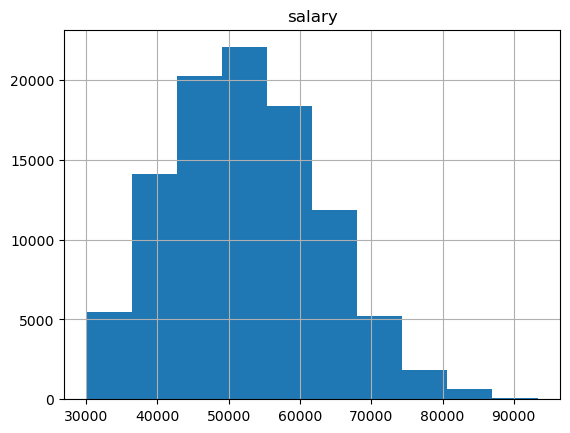

In [686]:
final_simulation.hist('salary')